In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import xarray as xr
from astropy.coordinates import get_sun, ITRS
from astropy.time import Time

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

samp_rate = 100
n_avg = 1000
T_avg = n_avg/samp_rate

In [2]:
def load_timeseries(filename, freq_tune = 0, freq_correct = 0, skip = 0):
    phase = np.fromfile(filename, dtype = 'float32')
    t_start = np.datetime64(filename.split('_')[-1].rstrip('.f32'))
    phase_correct = (freq_correct/samp_rate * 2 * np.pi * np.arange(phase.size)) % (2*np.pi)\
        if freq_correct != 0 else 0
    t = t_start + np.arange(0, phase.size, n_avg) * np.timedelta64(int(1e9/samp_rate), 'ns')
    f = np.diff(np.unwrap(phase + phase_correct)[::n_avg])/(2*np.pi*T_avg) + freq_tune
    return xr.DataArray(np.concatenate((f[skip:], [np.nan])), # note we insert a nan at the end to break up the series
                        coords = {'time' : t[skip:]}, dims = ('time'))

In [3]:
# Uncomment to process raw files
#

#f = xr.concat((load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-09T16:48:53.941246.f32',
#                               freq_correct=-25),
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-13T11:29:07.445732.f32',
#                               freq_correct=-25),
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-18T18:24:40.161949.f32',
#                               freq_correct=-25),
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-20T15:33:13.092955.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-20T16:53:26.606920.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-22T11:00:46.393010.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-22T18:17:49.641966.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-23T20:10:36.685659.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-24T16:25:48.828168.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-25T14:33:54.688566.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-30T16:11:13.380922.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-03-31T15:59:52.724251.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-02T09:50:15.976350.f32',
#                               freq_correct=65)[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-04T09:49:32.669375.f32',
#                               freq_correct=65)[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-04T10:57:56.173741.f32',
#                               freq_correct=65)[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-05T17:33:32.617400.f32',
#                               freq_correct=65)[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-11T14:20:57.257567.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-11T15:31:56.537078.f32')[10:],
#               load_timeseries('eclipse_season_march_2021/phase_bpsk_2021-04-12T15:50:23.296942.f32')[10:],
#              ), 'time')
#
#f.to_dataset(name = 'freq').to_netcdf('qo100_beacon_freq_spring_2021.nc')

In [4]:
f = xr.load_dataset('qo100_beacon_freq_spring_2021.nc')['freq']

In [5]:
# Invalidate noisy data points
cutoff = 1.0
invalidate = np.abs(np.diff(f)) >= cutoff
f[:-1][invalidate] = np.nan
f[1:][invalidate] = np.nan

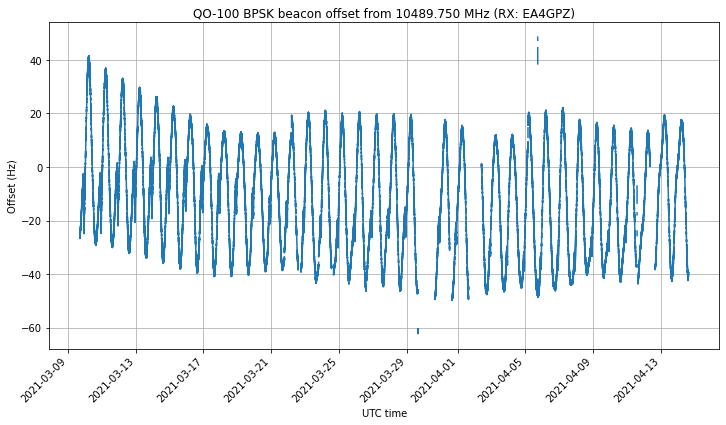

In [6]:
plt.figure(figsize = (12,6), facecolor = 'w')

f.plot()

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time')
plt.xticks(rotation = 45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid()

# eclipse calculator https://www.satellite-calculations.com/Satellite/satellite_eclipse.htm

#plt.axvspan(np.datetime64('2020-04-09T22:04:35'), np.datetime64('2020-04-09T22:31:40'),
#            color = 'grey', alpha = 0.3, label = 'Eclipse')
#plt.axvspan(np.datetime64('2020-04-10T22:08:33'), np.datetime64('2020-04-10T22:27:10'),
#            color = 'grey', alpha = 0.3)
#plt.legend();

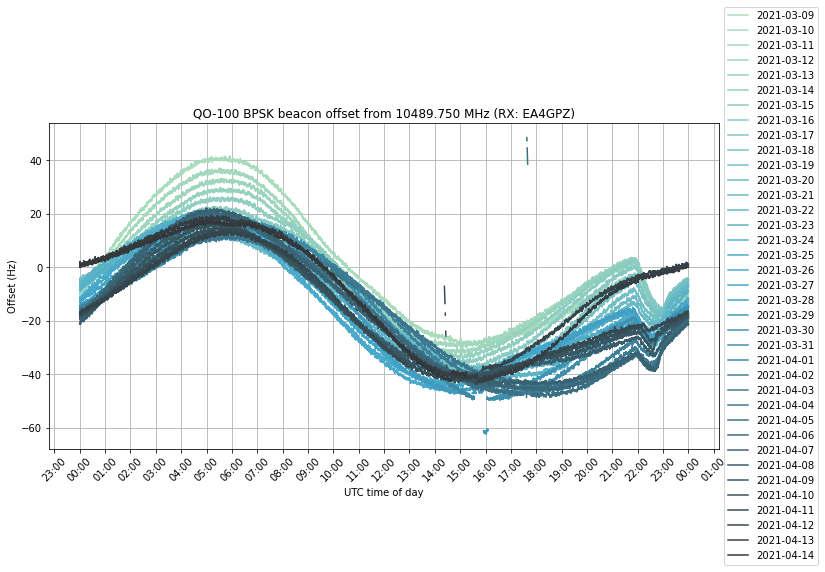

In [7]:
plt.figure(figsize = (12,6), facecolor = 'w')

offset_by_day = 0

f_res = f.resample(time = '1d')
with sns.color_palette('GnBu_d', len(f_res)):
    for j,d in enumerate(f_res):
        time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
        plt.plot(time_of_day, d[1] - offset_by_day*j, label = d[0].astype('datetime64[D]'))

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time of day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
#plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [8]:
sublat = 25.8
geo_R = 42164
earth_R = 6371
critical_angle = np.arcsin(earth_R/geo_R)
sat_ITRS_direction = np.array([np.cos(np.deg2rad(sublat)), np.sin(np.deg2rad(sublat)), 0])

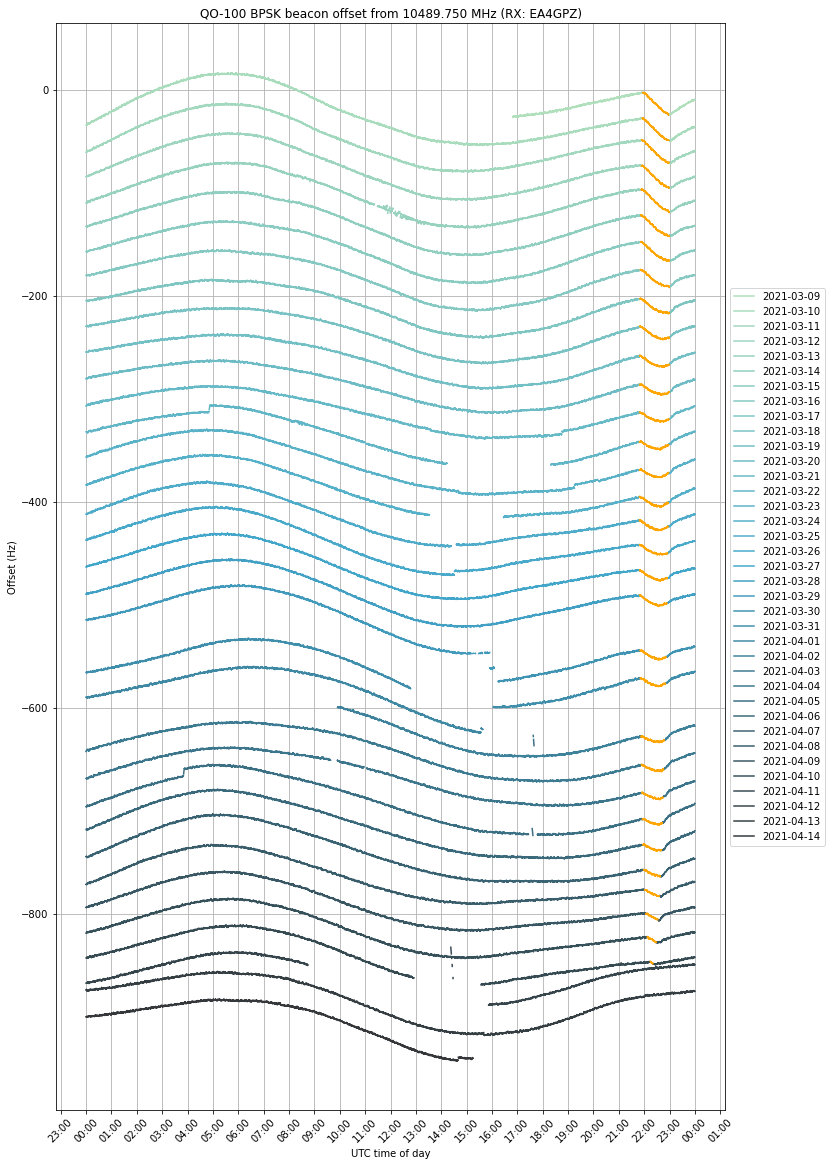

In [9]:
plt.figure(figsize = (12,20), facecolor = 'w')

offset_by_day = 25

with sns.color_palette('GnBu_d', len(f_res)):
    for j,d in enumerate(f_res):
        sun_pos = get_sun(Time(d[1].time)).transform_to(ITRS).cartesian.xyz.value
        sun_angle = np.arccos(
            -np.einsum('i,ij->j', sat_ITRS_direction, sun_pos)
            / np.sqrt(np.sum(sun_pos**2, axis = 0))
            )
        eclipse = sun_angle <= critical_angle
        time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
        dd = (d[1] - offset_by_day*j).copy()
        dd[eclipse] = np.nan
        plt.plot(time_of_day, dd, label = d[0].astype('datetime64[D]'))
        dd = (d[1] - offset_by_day*j).copy()
        dd[~eclipse] = np.nan
        plt.plot(time_of_day, dd, color = 'orange')

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time of day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

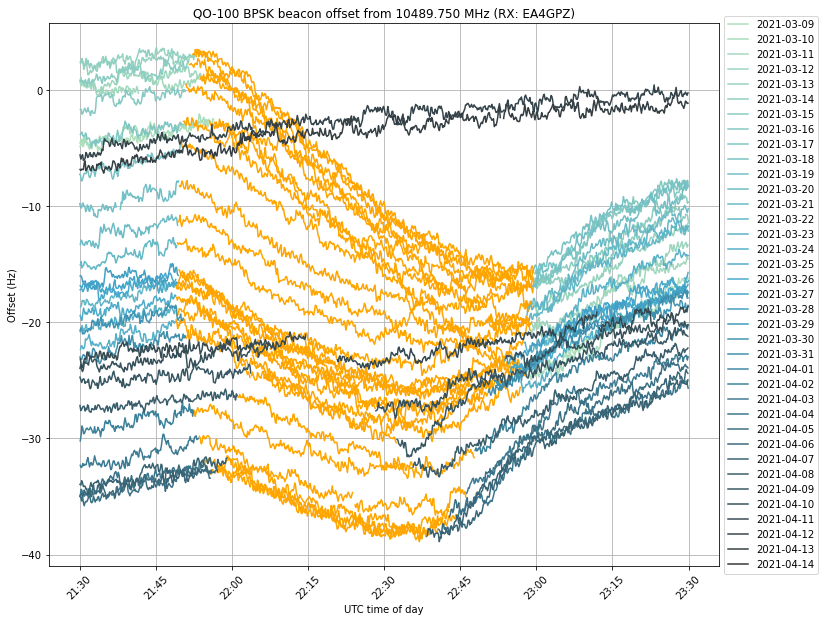

In [10]:
plt.figure(figsize = (12,10), facecolor = 'w')

offset_by_day = 0

with sns.color_palette('GnBu_d', len(f_res)):
    for j,d in enumerate(f_res):
        sun_pos = get_sun(Time(d[1].time)).transform_to(ITRS).cartesian.xyz.value
        sun_angle = np.arccos(
            -np.einsum('i,ij->j', sat_ITRS_direction, sun_pos)
            / np.sqrt(np.sum(sun_pos**2, axis = 0))
            )
        eclipse = sun_angle <= critical_angle
        time_of_day = d[1].time - d[1].time[0].astype('datetime64[D]') + np.datetime64('2000-01-01')
        sel_tod = ((time_of_day >= np.datetime64('2000-01-01T21:30')) 
                   & (time_of_day <= np.datetime64('2000-01-01T23:30')))
        dd = (d[1] - offset_by_day*j).copy()
        dd[eclipse] = np.nan
        plt.plot(time_of_day[sel_tod], dd[sel_tod], label = d[0].astype('datetime64[D]'))
        dd = (d[1] - offset_by_day*j).copy()
        dd[~eclipse] = np.nan
        plt.plot(time_of_day[sel_tod], dd[sel_tod], color = 'orange')

plt.title('QO-100 BPSK beacon offset from 10489.750 MHz (RX: EA4GPZ)')
plt.ylabel('Offset (Hz)')
plt.xlabel('UTC time of day')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.legend()
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));